# Segmentation Dataset

Create the automation for the segmentation dataset

In [54]:
import json
import rasterio
import skimage
import numpy as np
import pandas as pd
import geopandas as gpd
import seaborn as sns
import matplotlib.pyplot as plt

from pycocotools import mask
from rasterio.windows import Window
from rasterio.transform import from_gcps
from rasterio.control import GroundControlPoint as GCP
from shapely.geometry import Polygon

In [55]:
root = 'C:/Users/mikelaucella/Downloads'
usgs = 'E:/USGS'

In [3]:
meta_tx = pd.read_csv(f'{usgs}/meta/TX.csv')
meta_ca = pd.read_csv(f'{usgs}/meta/CA.csv')

## Get GeoMesh

Get the transformations and geo location per pixel mesh

In [4]:
def get_box_dec(df, img_id: str) -> list:
    row = df[df['Photo ID'] == img_id].iloc[0]

    ul = (row['NW Corner Long dec'], row['NW Corner Lat dec'])
    ll = (row['SW Corner Long dec'], row['SW Corner Lat dec'])
    lr = (row['SE Corner Long dec'], row['SE Corner Lat dec'])
    ur = (row['NE Corner Long dec'], row['NE Corner Lat dec'])

    return [ul, ll, lr, ur, ul]

def get_coord_mesh(transform, shape: tuple, chunk_shape: tuple=(1, 1)) -> tuple:
    row_indices = np.arange(0, shape[0], chunk_shape[0])
    col_indices = np.arange(0, shape[1], chunk_shape[1])
    rows, cols = np.meshgrid(row_indices, col_indices, indexing='ij')
    return transform * (rows, cols)

def get_transform(bbox, shape: tuple):
    ul, ll, lr, ur, _ = bbox
    cols, rows = shape

    gcps = [
        GCP(0, 0, *ul),
        GCP(0, cols, *ur),
        GCP(rows, 0, *ll),
        GCP(rows, cols, *lr)
    ]

    return from_gcps(gcps)

In [64]:
tif = rasterio.open(f'{usgs}/CA/L830280892246.tif')

c:\Users\mikelaucella\AppData\Local\miniconda3\envs\mlts2venv\Lib\site-packages\rasterio\__init__.py:368: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


In [5]:
bbox = get_box_dec(meta_ca, 'L830280892246')
bbox

[(-122.97055, 38.105668),
 (-122.94906, 38.086778),
 (-122.92517, 38.103777),
 (-122.94667, 38.122167),
 (-122.97055, 38.105668)]

In [9]:
transform = get_transform(bbox, tif.shape)
xs, ys = get_coord_mesh(transform, tif.shape, (1, 1))

## Get Segmentation Label

Get the segmentation mask for vegetation on a sample

In [65]:
cir = tif.read().transpose(1, 2, 0)

In [66]:
ndvi = cir / 255
ndvi = (ndvi[:, :, 0] - ndvi[:, :, 1]) / (ndvi[:, :, 0] + ndvi[:, :, 1] + 1e-10)
red_mask = (ndvi > 0.15)

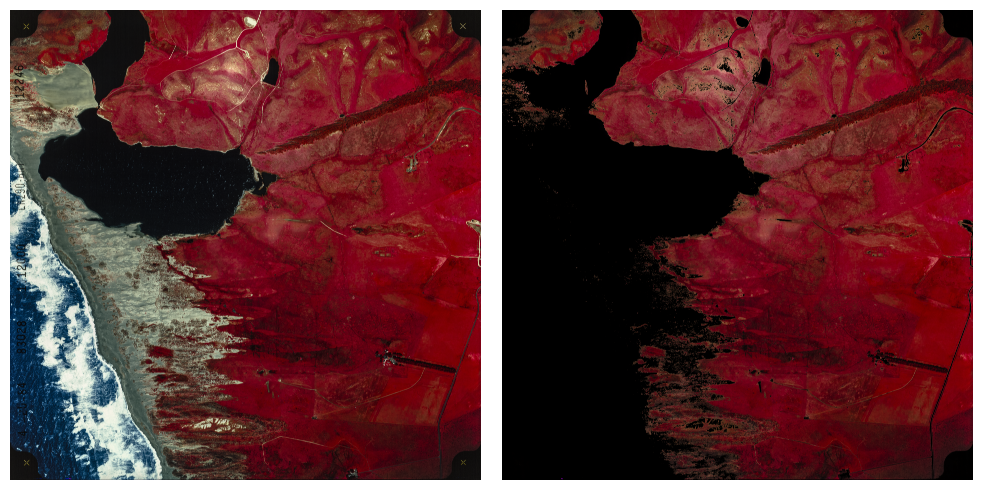

In [68]:
fig, axs = plt.subplots(1, 2, figsize=(10, 5))

axs[0].imshow(cir)
axs[0].axis('off')

axs[1].imshow(cir[..., :3] * np.stack([red_mask] * 3, axis=-1))
axs[1].axis('off')

plt.tight_layout()
plt.show()

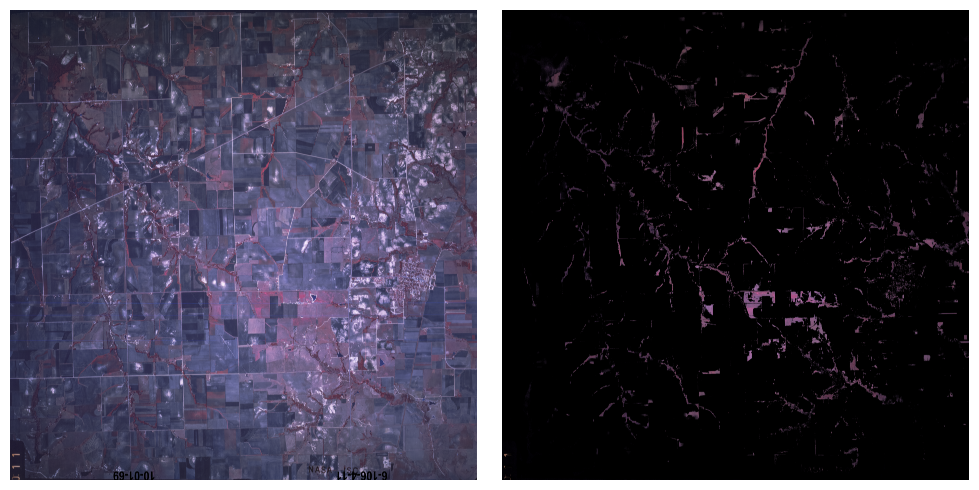

In [62]:
fig, axs = plt.subplots(1, 2, figsize=(10, 5))

axs[0].imshow(cir)
axs[0].axis('off')

axs[1].imshow(cir[..., :3] * np.stack([red_mask] * 3, axis=-1))
axs[1].axis('off')

plt.tight_layout()
plt.show()

## Get B&W Image

Convert the image to grayscale for the model to use

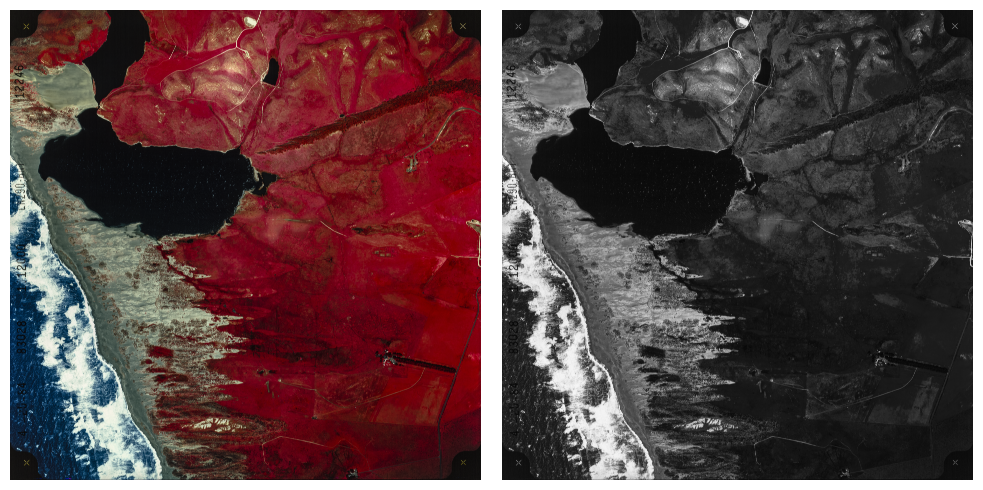

In [7]:
fig, axs = plt.subplots(1, 2, figsize=(10, 5))

axs[0].imshow(cir)
axs[0].axis('off')

axs[1].imshow(skimage.color.rgb2gray(skimage.color.rgba2rgb(cir)), cmap='gray')
axs[1].axis('off')

plt.tight_layout()
plt.show()

## Get Chunk Windows

Get the chunk window plan for execution

In [107]:
def get_windows(img_shape: tuple, chunk_size: int=224, offset: int=0) -> list:
    chunk_rows = (img_shape[0] - offset * 2) // 224
    chunk_cols = (img_shape[1] - offset * 2) // 224

    windows = []

    for i in range(chunk_rows):
        row_offset = offset + i * chunk_size

        for j in range(chunk_cols):
            col_offset = offset + j * chunk_size

            windows.append(Window(row_offset, col_offset, chunk_size, chunk_size))

    return windows

def window_to_poly(xs: np.array, ys: np.array, window: Window) -> Polygon:
    row = window.row_off
    col = window.col_off
    height = window.height
    width = window.width

    return Polygon([
        (xs[row, col], ys[row, col]),
        (xs[row + height, col], ys[row + height, col]),
        (xs[row + height, col + width], ys[row + height, col + width]),
        (xs[row, col + width], ys[row, col + width]),
        (xs[row, col], ys[row, col])
    ])

In [108]:
windows = get_windows(tif.shape, chunk_size=224, offset=450)
len(windows)

1296

Text(0.5, 1.0, 'Image Chunk Planning')

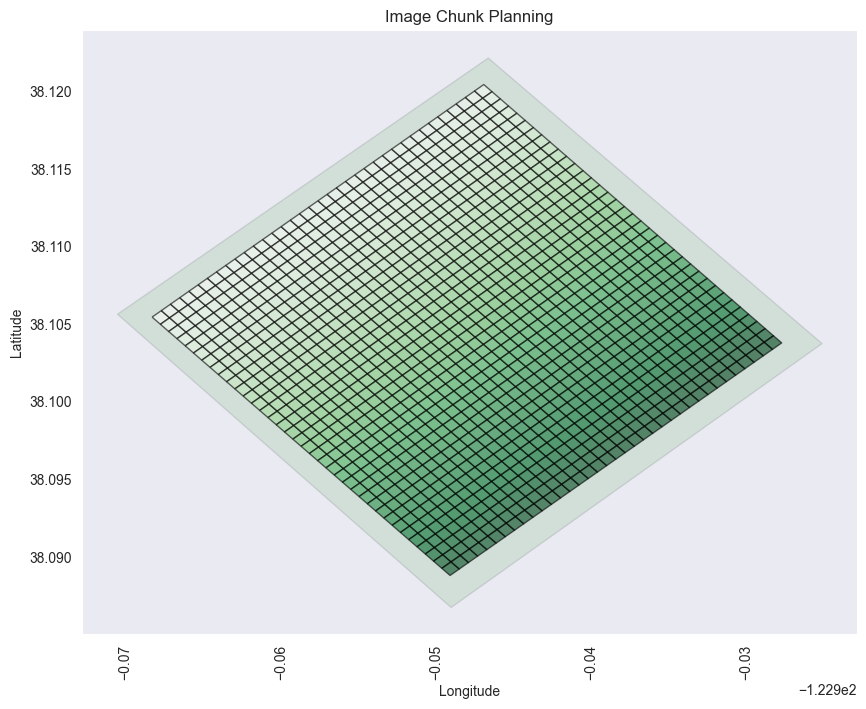

In [109]:
sns.set_style('dark')

fig, ax = plt.subplots(figsize=(10, 10))

gpd.GeoDataFrame(geometry=[
    Polygon([bbox[0], bbox[1], bbox[2], bbox[3], bbox[0]])
]).plot(color='Green', ax=ax, alpha=0.1, edgecolor='black')

gpd.GeoDataFrame(geometry=[
    window_to_poly(xs, ys, window) for window in windows
]).plot(cmap='Greens', ax=ax, alpha=0.6, edgecolor='black')

plt.xticks(rotation=90)
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Image Chunk Planning')

## Get Chunks

Sample a chunk from the windows

In [110]:
chunk1 = tif.read(window=windows[0])

red_mask = (chunk1[0] > 60) & (chunk1[1] < 60) & (chunk1[2] < 60)

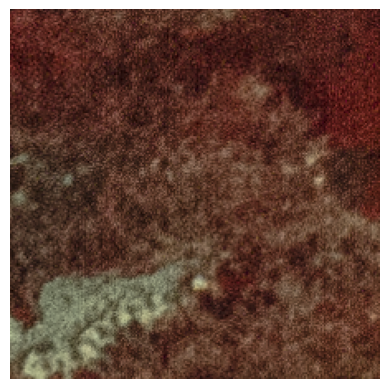

In [111]:
plt.imshow(chunk1.transpose(1, 2, 0))
plt.axis('off')
plt.show()

In [112]:
tif.close()

## COCO Formatting

Encode the metadata for the chunk using CoCo format

In [74]:
rle = mask.encode(np.asfortranarray(red_mask))
rle['counts'] = rle['counts'].decode('ascii')

In [75]:
annotation = {
    "id": 1,
    "category_id": 1,
    "iscrowd": 0,
    "image_id": 'L830280892246_1',
    "segmentation": rle,
    "area": mask.area(rle).tolist(),
    "bbox": mask.toBbox(rle).tolist()
    # TODO: add additional meta data here
    "date": None,
    "altitude": None,
    "geometry": None
}

In [76]:
with open('annotation.json', 'w') as f:
    json.dump(annotation, f)

## Confirm Annotation

Confirm the RLE encoding retains the original segmentation mask

In [85]:
red_mask_decoded = mask.decode(rle)

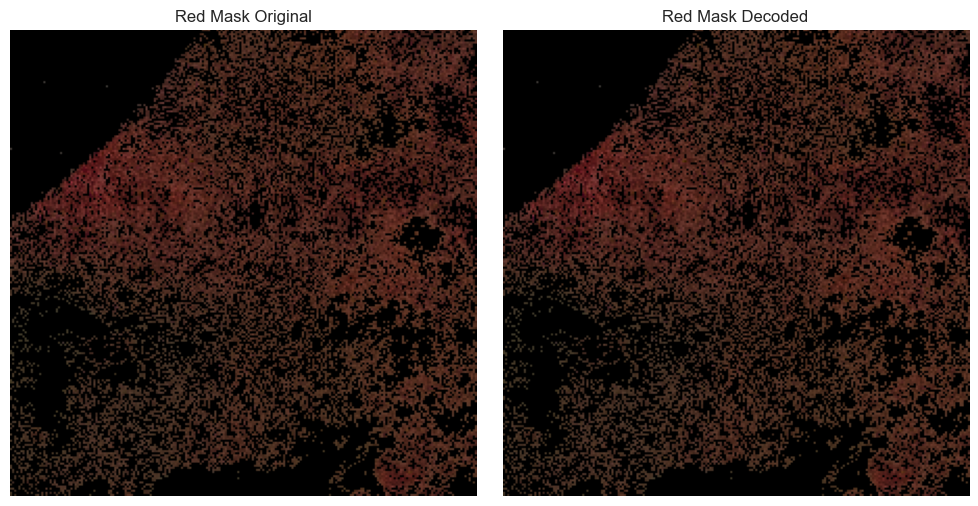

In [87]:
fig, axs = plt.subplots(1, 2, figsize=(10, 5))

axs[0].imshow(chunk1.transpose(1, 2, 0)[..., :3] * np.stack([red_mask] * 3, axis=-1))
axs[0].axis('off')
axs[0].set_title('Red Mask Original')

axs[1].imshow(chunk1.transpose(1, 2, 0)[..., :3] * np.stack([red_mask_decoded] * 3, axis=-1))
axs[1].axis('off')
axs[1].set_title('Red Mask Decoded')

plt.tight_layout()
plt.show()